In [1]:
import time
import pymysql
import pandas as pd
import numpy as np
from datetime import datetime as dt
import datetime
from datetime import date as dtt

from sklearn.preprocessing import LabelEncoder,StandardScaler  

# libraries for visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objs as go
import cufflinks as cf
from plotly.offline import iplot, init_notebook_mode, plot
cf.go_offline()

import warnings
warnings.filterwarnings("ignore")

In [19]:
import time
import pymysql
import pandas as pd

start_time = time.time()

conn = pymysql.connect(
  host="cpt-hq-db02-b55.hq.takealot.com",
  user="lindani.mncwabe",
  passwd="aV3n6MehTad0R",
  database="take2"
)

mycursor = conn.cursor()

mycursor.execute('''

select rr.idProduct, sum(rr.QtyAccepted) as Units_Returned, ts.Description, ts.AddedDate as Product_Date_Added,
sel.DateAdded as Seller_Date_Added
from take2.rrn_returns rr
      left join supply_chain.business_hierarchy bh on bh.idProduct = rr.idProduct
      left join take2.tsins ts on ts.idTsin = bh.idTsin
      left join take2.rrn_return_evaluation_report ev on rr.idRrnReturn = ev.rrn_return_id
      left join take2.products p on p.idProduct = rr.idProduct
      left join take2.seller_listings sl on bh.idTsin = sl.idTsin
      left join take2.sellers sel on sel.idSeller=sl.idSeller
where rr.DetailsReason = "The product is defective or damaged"
and rr.WhenCreated >= '2021-05-02'
and rr.QtyAccepted IS NOT NULL
#and p.Active =1
and ev.evaluation_outcome not in ('decline')
group by rr.idProduct

''')

myresult = mycursor.fetchall()

df = pd.read_sql_query(
'''

select rr.idProduct, sum(rr.QtyAccepted) as Units_Returned, ts.Description, ts.AddedDate as Product_Date_Added,
sel.DateAdded as Seller_Date_Added
from take2.rrn_returns rr
      left join supply_chain.business_hierarchy bh on bh.idProduct = rr.idProduct
      left join take2.tsins ts on ts.idTsin = bh.idTsin
      left join take2.rrn_return_evaluation_report ev on rr.idRrnReturn = ev.rrn_return_id
      left join take2.products p on p.idProduct = rr.idProduct
      left join take2.seller_listings sl on bh.idTsin = sl.idTsin
      left join take2.sellers sel on sel.idSeller=sl.idSeller
where rr.DetailsReason = "The product is defective or damaged"
and rr.WhenCreated >= '2021-05-02'
and rr.QtyAccepted IS NOT NULL
#and p.Active =1
and ev.evaluation_outcome not in ('decline')
group by rr.idProduct

''',conn)

print("--- %s seconds ---" % (time.time() - start_time))
df.head()

--- 338.89044213294983 seconds ---


,idProduct,Units_Returned,Description,Product_Date_Added,Seller_Date_Added
0,111570,2.0,"<p>In 1914, a room full of German schoolboys, ...",2015-03-24 00:00:00,2020-07-01 17:40:05
1,148822,2.0,"<p>Drawn from 3,000 years of the history of po...",2015-03-25 00:00:00,2020-07-01 17:40:05
2,535137,2.0,<p>Aspiring writer Hubbell Gardiner (Robert Re...,2005-08-19 13:15:32,2021-10-22 10:49:33
3,1973824,1.0,Bittersweet romantic comedy from writer-direct...,2006-07-28 14:24:44,2021-10-22 10:49:33
4,2071831,2.0,<p><br></p>,2006-09-04 16:20:47,2021-10-22 10:49:33


In [5]:
sales_df = pd.read_excel (r'C:\Users\mncedisi.mncwabe\Documents\Returns - Model development\Pre-model\sales.xlsx')
sales_df.head()

,idProduct,TSIN Title,QTY
0,8,Mad Max: Beyond The Thunderdome (DVD),10
1,9,Men Of Honour (DVD),5
2,14,Speed 2 (DVD),19
3,16,Predator 2 (1990) (DVD),3
4,37,Training Day (2001) (DVD),3


In [20]:
df.shape

(81860, 5)

In [21]:
sales_df.shape

(531092, 3)

In [22]:
df = pd.merge(sales_df, df, how='left', on=['idProduct'])

In [23]:
df.head()

,idProduct,TSIN Title,QTY,Units_Returned,Description,Product_Date_Added,Seller_Date_Added
0,8,Mad Max: Beyond The Thunderdome (DVD),10,NaN,NaN,NaT,NaT
1,9,Men Of Honour (DVD),5,NaN,NaN,NaT,NaT
2,14,Speed 2 (DVD),19,NaN,NaN,NaT,NaT
3,16,Predator 2 (1990) (DVD),3,NaN,NaN,NaT,NaT
4,37,Training Day (2001) (DVD),3,NaN,NaN,NaT,NaT


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 531092 entries, 0 to 531091
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   idProduct           531092 non-null  int64         
 1   TSIN Title          531092 non-null  object        
 2   QTY                 531092 non-null  int64         
 3   Units_Returned      64315 non-null   float64       
 4   Description         64233 non-null   object        
 5   Product_Date_Added  62664 non-null   datetime64[ns]
 6   Seller_Date_Added   60066 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2), object(2)
memory usage: 32.4+ MB


In [11]:
# create target variable - whether a product was returned or not
#df['is_returned'] = np.where((df.Units_Returned.isnull()),'0','1')

In [25]:
df['Units_Returned'] = np.where((df.Units_Returned.isnull()),0,df['Units_Returned'])

In [26]:
# create target variable - whether a product was returned or not
df['is_returned']=np.where((df['Units_Returned']>=3) & (df['QTY']>=10),1,0)

In [27]:
df['return_rate'] = df['Units_Returned']/df['QTY']*100

In [28]:
df.head()

,idProduct,TSIN Title,QTY,Units_Returned,Description,Product_Date_Added,Seller_Date_Added,is_returned,return_rate
0,8,Mad Max: Beyond The Thunderdome (DVD),10,0.0,NaN,NaT,NaT,0,0.0
1,9,Men Of Honour (DVD),5,0.0,NaN,NaT,NaT,0,0.0
2,14,Speed 2 (DVD),19,0.0,NaN,NaT,NaT,0,0.0
3,16,Predator 2 (1990) (DVD),3,0.0,NaN,NaT,NaT,0,0.0
4,37,Training Day (2001) (DVD),3,0.0,NaN,NaT,NaT,0,0.0


In [29]:
df.isnull().sum().sort_values(ascending = False)/len(df)*100 

Seller_Date_Added     88.690095
Product_Date_Added    88.200914
Description           87.905485
idProduct              0.000000
TSIN Title             0.000000
QTY                    0.000000
Units_Returned         0.000000
is_returned            0.000000
return_rate            0.000000
dtype: float64

In [30]:
df.describe()

,idProduct,QTY,Units_Returned,is_returned,return_rate
count,5.310920e+05,531092.000000,531092.000000,531092.000000,531092.000000
mean,8.937405e+07,18.201054,3.457881,0.048491,17.420969
std,1.846305e+07,165.828346,111.758484,0.214801,222.578344
min,8.000000e+00,1.000000,0.000000,0.000000,0.000000
25%,8.392630e+07,1.000000,0.000000,0.000000,0.000000
50%,9.536033e+07,3.000000,0.000000,0.000000,0.000000
75%,1.036426e+08,10.000000,0.000000,0.000000,0.000000
max,1.061392e+08,84499.000000,52722.000000,1.000000,43500.000000


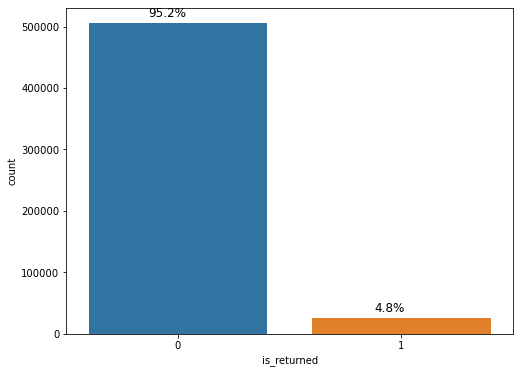

In [31]:
# check the distribution of the target variable - returned (1) vs not-returned(0)
def target(plot, feature):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        plot.annotate(percentage, (x, y), size = 12,ha = 'center', va = 'center', xytext = (0, 10), 
                                                                        textcoords = 'offset points')
    plt.show()

plt.figure(figsize=(8, 6))
plot = sns.countplot(df['is_returned'])


target(plot,df.is_returned)

In [77]:
df['Product_Age']=dt.today()-df['Product_Date_Added']
df['Product_Age'] = df['Product_Age'].dt.days.astype('int16',errors='ignore')

# convert to years
df['Product_Age'] = round(df['Product_Age']/365)
df['Product_Age'] = df['Product_Age'].astype('int16',errors='ignore')

In [44]:
df['Seller_Age'] = dt.today()-df['Seller_Date_Added']
df['Seller_Age'] = df['Seller_Age'].dt.days.astype('int16',errors='ignore')

df['Seller_Age'] = round(df['Seller_Age']/365)
df['Seller_Age'] = df['Seller_Age'].astype('int16',errors='ignore')

In [12]:
#df2['Customer_Age'] = dt.today()-df2['Customer_Date_Added']

#df2['Customer_Age'] = df2['Customer_Age'].dt.days.astype('int16',errors='ignore')

#convert to years
#df2['Customer_Age'] = df2['Customer_Age']/365
#df2['Customer_Age'] = df2['Customer_Age'].astype('int16',errors='ignore')

In [15]:
#df2['Seller_Age'] = dt.today()-df2['Seller_Date_Added']
#df2['Seller_Age'] = df2['Seller_Age'].dt.days.astype('int16',errors='ignore')

# convert to years
#df2['Seller_Age'] = df2['Seller_Age']/365
#df2['Seller_Age'] = df2['Seller_Age'].astype('int16',errors='ignore')

In [16]:
#df2['Waiting_Time']=(pd.to_datetime(df2['DateDelivered']) -pd.to_datetime(df2['OrderDate']))
#df2['Waiting_Time'] = df2['Waiting_Time'].dt.days.astype('int16',errors='ignore')

In [17]:
#df2['Order_Size'] = df2.groupby(['idOrder'])['idProduct'].transform('count')

In [19]:
#df2['Waiting_Time']=np.where((df2['Waiting_Time']<0),0,df2['Waiting_Time'])

<AxesSubplot:xlabel='Product_Age', ylabel='Units_Returned'>

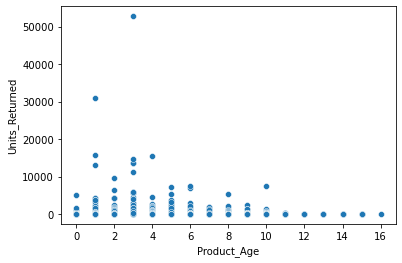

In [52]:
sns.scatterplot(data = df, x = 'Product_Age', y = 'Units_Returned')

<AxesSubplot:xlabel='Seller_Age', ylabel='Units_Returned'>

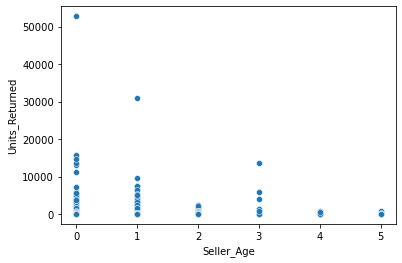

In [53]:
sns.scatterplot(data = df, x = 'Seller_Age', y = 'Units_Returned')

In [24]:
#target variable (is_returned) is stored as onject type, convert it to int
#df2['is_returned']=df2['is_returned'].astype(str).astype(int)

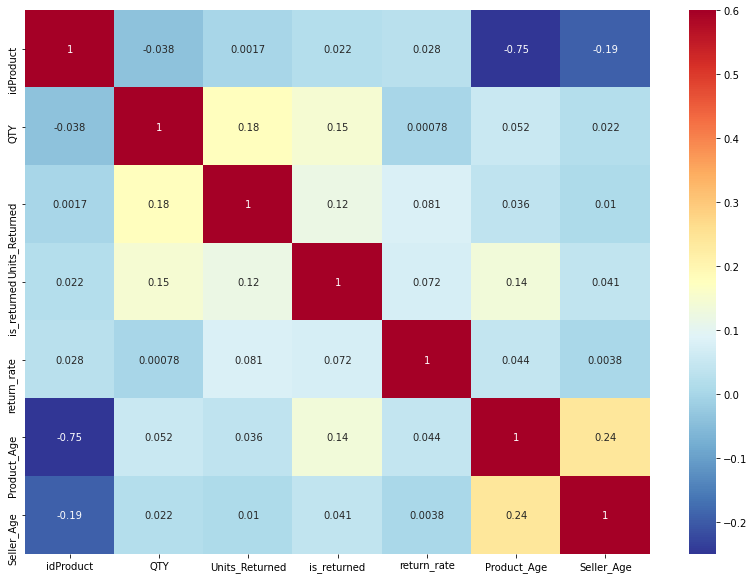

In [55]:
plt.figure(figsize = (14,10))

sns.heatmap(df.corr(), cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6);

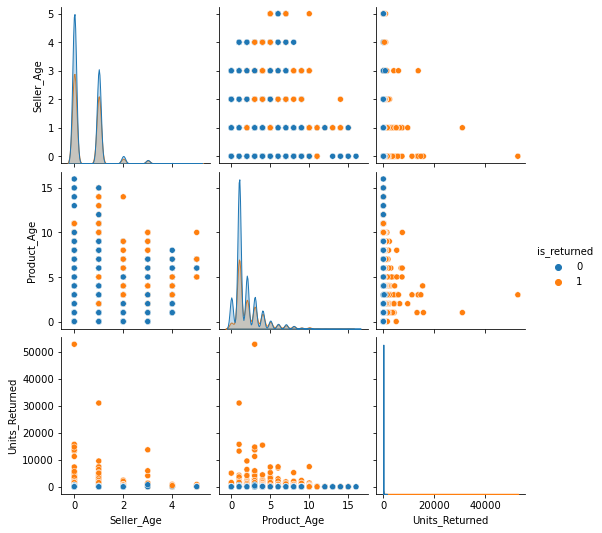

In [61]:
corr = ['Seller_Age','Product_Age','Units_Returned','is_returned']
corr_data = df.loc[:,corr]
sns.pairplot(corr_data, hue = 'is_returned')

In [62]:
import re

# Define a function to clean the product description column
def clean(text):
    # Removes all special characters and numericals leaving the alphabets
    text = re.sub('[^A-Za-z]+', ' ', str(text))
    return text

# Cleaning the text in the review column
df['Cleaned_Description'] = df['Description'].apply(clean)
df.head()

,idProduct,TSIN Title,QTY,Units_Returned,Description,Product_Date_Added,Seller_Date_Added,is_returned,return_rate,Product_Age,Seller_Age,Cleaned_Description
0,8,Mad Max: Beyond The Thunderdome (DVD),10,0.0,NaN,NaT,NaT,0,0.0,NaN,NaN,nan
1,9,Men Of Honour (DVD),5,0.0,NaN,NaT,NaT,0,0.0,NaN,NaN,nan
2,14,Speed 2 (DVD),19,0.0,NaN,NaT,NaT,0,0.0,NaN,NaN,nan
3,16,Predator 2 (1990) (DVD),3,0.0,NaN,NaT,NaT,0,0.0,NaN,NaN,nan
4,37,Training Day (2001) (DVD),3,0.0,NaN,NaT,NaT,0,0.0,NaN,NaN,nan


In [63]:
df['Desc_count']= np.where((df.Description.isnull()),0,df['Cleaned_Description'].str.split().str.len())

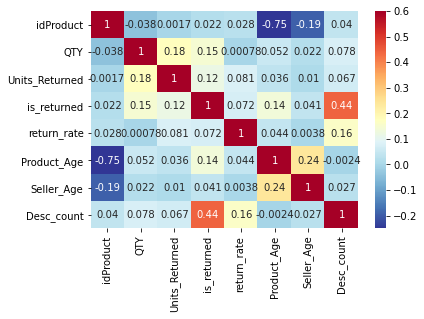

In [64]:
sns.heatmap(df.corr(), cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6);

<AxesSubplot:xlabel='Desc_count', ylabel='Units_Returned'>

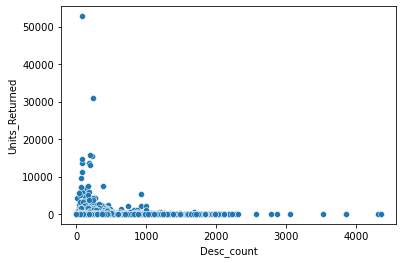

In [65]:
sns.scatterplot(data = df, x = 'Desc_count', y = 'Units_Returned')

<AxesSubplot:xlabel='Product_Age', ylabel='Units_Returned'>

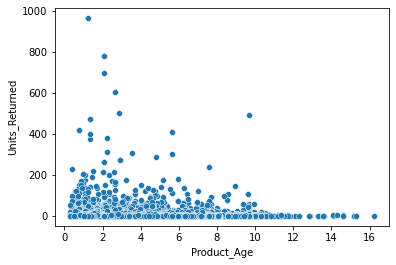

In [272]:
sns.scatterplot(data = df, x = 'Product_Age', y = 'Units_Returned')

In [227]:
cols=['idProduct','Product_Age','is_returned','Desc_count','Seller_Age', 'QTY']

train_data = df.loc[:,cols]

In [228]:
train_data.head()

,idProduct,Product_Age,is_returned,Desc_count,Seller_Age,QTY
0,8,NaN,0,0,NaN,10
1,9,NaN,0,0,NaN,5
2,14,NaN,0,0,NaN,19
3,16,NaN,0,0,NaN,3
4,37,NaN,0,0,NaN,3


In [229]:
train_data.isnull().sum().sort_values(ascending = False)/len(train_data)*100 

Seller_Age     88.690095
Product_Age    88.200914
idProduct       0.000000
is_returned     0.000000
Desc_count      0.000000
QTY             0.000000
dtype: float64

In [230]:
train_data['Seller_Age'].fillna((train_data['Seller_Age'].mean()), inplace=True)
train_data['Product_Age'].fillna((train_data['Product_Age'].mean()), inplace=True)

train_data['Seller_Age']  = round(train_data['Seller_Age'])
train_data['Product_Age'] = round(train_data['Product_Age'])

In [231]:
train_data.isnull().sum().sort_values(ascending = False)/len(train_data)*100 

idProduct      0.0
Product_Age    0.0
is_returned    0.0
Desc_count     0.0
Seller_Age     0.0
QTY            0.0
dtype: float64

In [232]:
#le = LabelEncoder()
#train_data['PaymentMethod'] = le.fit_transform(train_data['PaymentMethod'])

In [233]:
# one hot encoding
#train_data = pd.concat([train_data,pd.get_dummies(train_data['PaymentMethod'], prefix = 'PaymentMethod')], axis=1)

In [234]:
#train_data = train_data.drop('PaymentMethod',axis=1)

In [235]:
train_data.head()

,idProduct,Product_Age,is_returned,Desc_count,Seller_Age,QTY
0,8,2.0,0,0,0.0,10
1,9,2.0,0,0,0.0,5
2,14,2.0,0,0,0.0,19
3,16,2.0,0,0,0.0,3
4,37,2.0,0,0,0.0,3


In [236]:
train_data.shape

(531092, 6)

In [237]:
train_data.skew()

idProduct       -1.699930
Product_Age      5.630544
is_returned      4.203997
Desc_count       9.932624
Seller_Age       6.230335
QTY            289.746087
dtype: float64

In [240]:
main_data = train_data[(train_data['is_returned']==1) | (train_data['is_returned']==0)].sample(frac=0.5)

In [241]:
test_data = train_data[~train_data.isin(main_data)].dropna(how = 'all')

In [242]:
print(main_df.shape)
print(test_df.shape)

(265546, 6)
(265546, 6)


In [243]:
main_data.head()

,idProduct,Product_Age,is_returned,Desc_count,Seller_Age,QTY
471911,104487528,2.0,0,0,0.0,1
232167,93709315,2.0,0,0,0.0,1
209353,93246053,2.0,0,0,0.0,2
232014,93707080,1.0,1,93,1.0,470
370691,101584282,2.0,0,0,0.0,3


In [244]:
test_data.head()

,idProduct,Product_Age,is_returned,Desc_count,Seller_Age,QTY
1,9.0,2.0,0.0,0.0,0.0,5.0
2,14.0,2.0,0.0,0.0,0.0,19.0
3,16.0,2.0,0.0,0.0,0.0,3.0
4,37.0,2.0,0.0,0.0,0.0,3.0
5,45.0,2.0,0.0,0.0,0.0,16.0


In [245]:
# import machine learning libraries that will be used
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, f1_score
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import confusion_matrix, precision_score, plot_confusion_matrix,classification_report
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import precision_recall_curve

from xgboost import XGBClassifier

In [246]:
X = main_data.drop(['is_returned','idProduct'],axis=1)
y = main_data['is_returned']

In [247]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=100)

In [248]:
#scalar = MinMaxScaler()
#X_train = scalar.fit_transform(X_train)
#X_test = scalar.transform(X_test)

In [249]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(185882, 4) (185882,)
(79664, 4) (79664,)


In [308]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100,max_depth=16,criterion='gini',class_weight='balanced',n_jobs=-1
                            ,min_samples_split=10,max_leaf_nodes=5,max_features=0.01,bootstrap=True)
rf.fit(X_train,y_train)
print('accurary(%):',rf.score(X_test,y_test)*100)

accurary(%): 97.2898674432617


In [309]:
y_pred_train = rf.predict(X_train)

y_pred_test = rf.predict(X_test)

In [310]:
print("Training accuracy: ", accuracy_score(y_train, y_pred_train))
print("Testing accuracy: ", accuracy_score(y_test, y_pred_test))

Training accuracy:  0.9730527969356904
Testing accuracy:  0.972898674432617


In [253]:
# XGBoost

# XGBoost works by correcting the previous mistake done by the model, 
# it learns from it and its next step improves the performance. 
# The previous results are rectified and performance is enhanced.
# This gets continued until there is no scope of further improvements. 
# Regularization is the feature that is dominant for this type of predictive algorithm. 
# It is fast to execute and gives good accuracy. 
# It has an ability to handle missing values, imbalanced data and prevent overfitting (using learning_rate).

xgb = XGBClassifier(n_estimators=100,max_depth=11,learning_rate=0.1,class_weight='balanced',criterion='friedman_mse',
                objective = "binary:logistic",min_samples_split=10,max_leaf_nodes=42,max_features=0.79,
                    bootstrap=False,verbose=0)
xgb.fit(X_train,y_train)
print('accuracy:',xgb.score(X_test,y_test)*100)

[14:21:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "bootstrap", "class_weight", "criterion", "max_features", "max_leaf_nodes", "min_samples_split", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:21:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
accuracy: 97.54845350471982


In [254]:
# Logistic regression
lr = LogisticRegression(solver='newton-cg',class_weight='balanced')
lr.fit(X_train,y_train)
print('accuracy:',lr.score(X_test,y_test)*100)

accuracy: 92.84620405703956


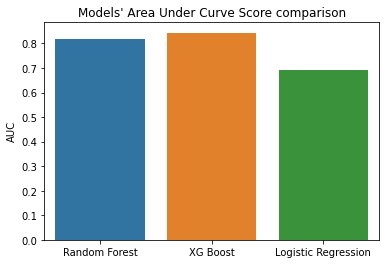

In [311]:
# Graphical representation of the model's AUC comparison 

sns.barplot(x=["Random Forest","XG Boost","Logistic Regression"],
            y=[roc_auc_score(rf.predict(X_test),y_test),roc_auc_score(xgb.predict(X_test),y_test),
               roc_auc_score(lr.predict(X_test),y_test)])
plt.ylabel("AUC")
plt.title("Models' Area Under Curve Score comparison")
plt.show()

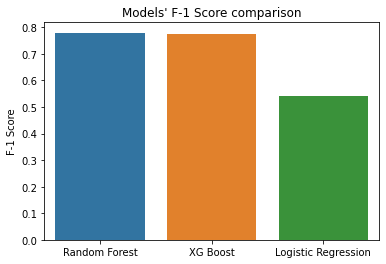

In [312]:
# Graphical representation of the model's F-1 Score comparison 
sns.barplot(x=["Random Forest","XG Boost","Logistic Regression"],
            y=[f1_score(rf.predict(X_test),y_test),f1_score(xgb.predict(X_test),y_test),
               f1_score(lr.predict(X_test),y_test)])
plt.ylabel("F-1 Score")
plt.title("Models' F-1 Score comparison")
plt.show()

In [313]:
y_pred = rf.predict(X_test)

Precision Score: 63.917698


<Figure size 720x432 with 0 Axes>

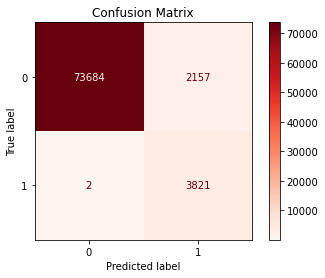

In [314]:
# Evaluate the RF model using Confusion matrix
plt.figure(figsize=(10,6))

print("Precision Score: %f" % (precision_score(y_test, y_pred) * 100))
plot_confusion_matrix(rf, X_test, y_test, cmap=plt.cm.Reds)
plt.title("Confusion Matrix")
plt.show()

In [259]:
X_train.shape

(185882, 4)

In [260]:
main_data.shape

(265546, 6)

In [261]:
cm = np.array(confusion_matrix(y_test, y_pred, labels=[0,1]))

confusion_mat= pd.DataFrame(cm, index = ["Not-Returned", "Returned"],
                           columns =["Predicted Not Returned", "Predicted Returned"])

confusion_mat

,Predicted Not Returned,Predicted Returned
Not-Returned,73240,2601
Returned,2,3821


In [315]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     75841
           1       0.64      1.00      0.78      3823

    accuracy                           0.97     79664
   macro avg       0.82      0.99      0.88     79664
weighted avg       0.98      0.97      0.98     79664



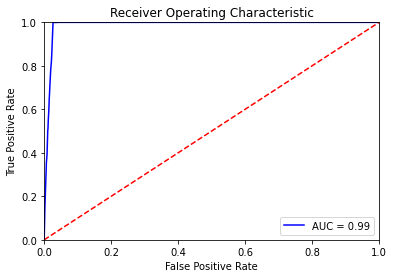

In [316]:
# ROC CURVE FOR THE RF MODEL
probs = rf.predict_proba(X_test)  
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [317]:
y_score = rf.predict_proba(X_test)[:, 1]

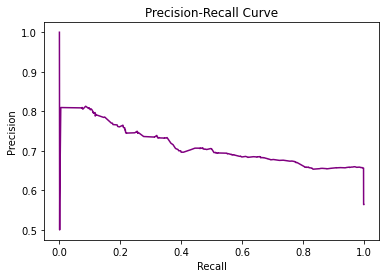

In [318]:
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

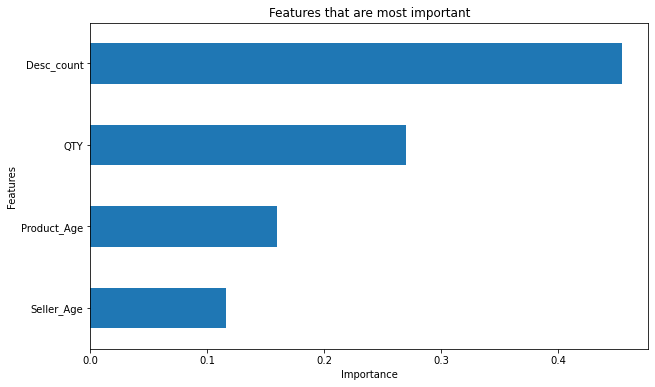

In [319]:
# Important features
# The feature importances in a random forest indicate the sum of the reduction in Gini Impurity 

plt.figure(figsize=(10,6))

feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nsmallest(40).plot(kind='barh')
importances = rf.feature_importances_
indices = np.argsort(importances)


plt.xlabel('Importance')
plt.ylabel('Features')
plt.title("Features that are most important")
plt.show()

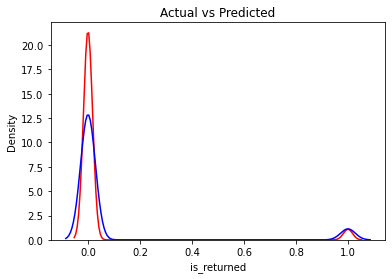

In [267]:
ax = sns.distplot(y, hist=False, color="r", label="Actual Value")
sns.distplot(y_pred, hist=False, color="b", label="Fitted Values" , ax=ax)
plt.title('Actual vs Predicted')
plt.show()
plt.close()

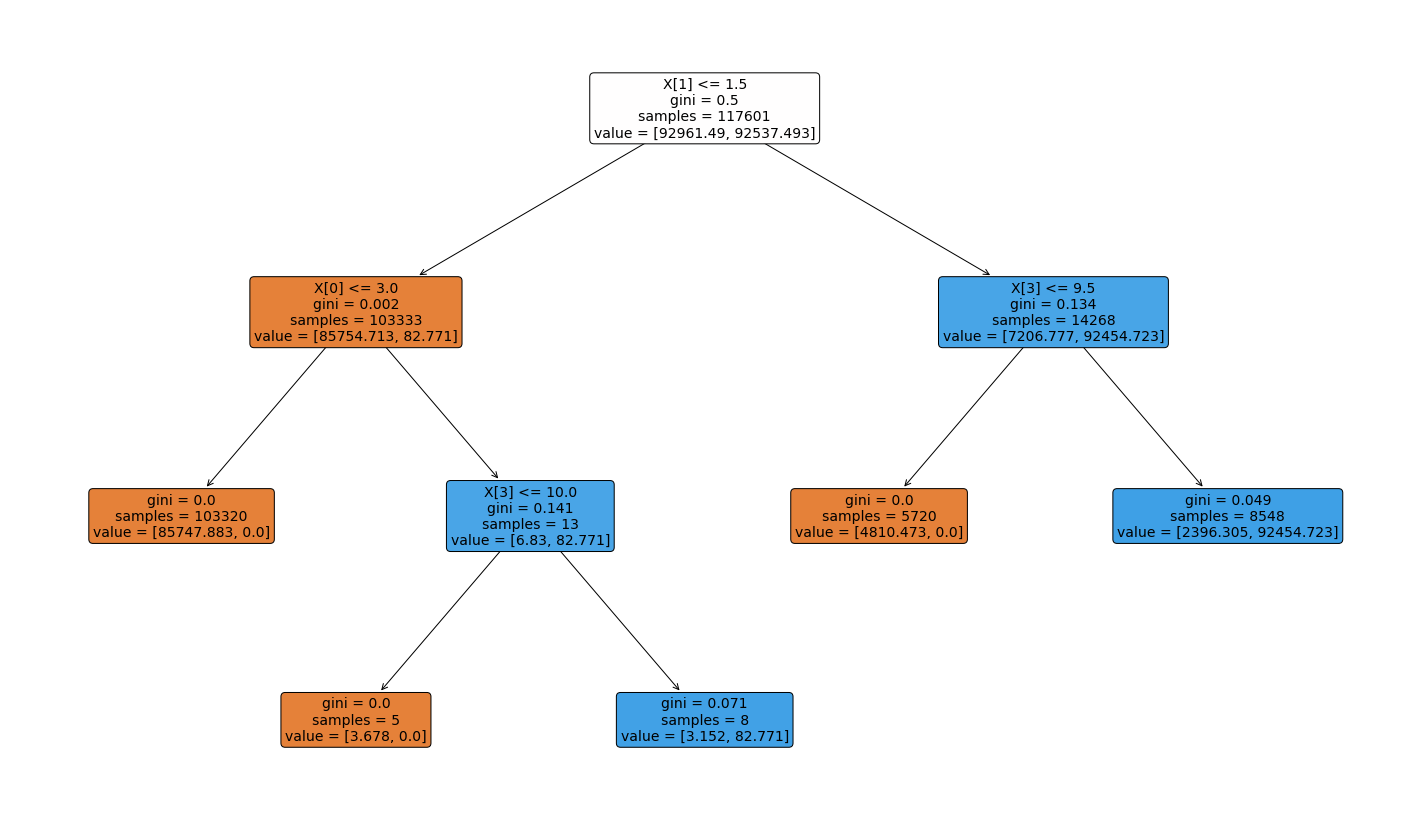

In [151]:
import pydot
# Pull out one tree from the forest
Tree = rf.estimators_[5]
# Export the image to a dot file
from sklearn import tree
plt.figure(figsize=(25,15))
tree.plot_tree(Tree,filled=True, 
              rounded=True, 
              fontsize=14);

### Use the trained model to predict the outcome of the held out set (which we know aleady has a label)

In [325]:
newdata = test_data.drop(['is_returned','idProduct'],axis=1)

In [326]:
new_data_pred = rf.predict(newdata)

In [327]:
id_product = test_data.set_index('idProduct')

In [328]:
product_index = id_product.index

In [329]:
predictions_table = {'id_product': product_index, 'return_predicted':new_data_pred, 'return_actual':test_data['is_returned']}
predictions = pd.DataFrame(predictions_table)
predictions = predictions[['id_product', 'return_predicted','return_actual']]

In [330]:
predictions.head()

,id_product,return_predicted,return_actual
1,9.0,0,0.0
2,14.0,0,0.0
3,16.0,0,0.0
4,37.0,0,0.0
5,45.0,0,0.0


In [266]:
predictions.to_csv('predictions.csv')

Precision Score: 64.493335


<Figure size 720x432 with 0 Axes>

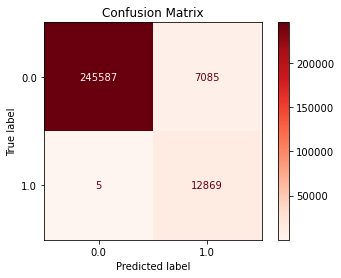

In [331]:
plt.figure(figsize=(10,6))

print("Precision Score: %f" % (precision_score(test_data['is_returned'], new_data_pred) * 100))
plot_confusion_matrix(rf, newdata, test_data['is_returned'], cmap=plt.cm.Reds)
plt.title("Confusion Matrix")
plt.show()

In [332]:
print(classification_report(test_data['is_returned'], new_data_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99    252672
         1.0       0.64      1.00      0.78     12874

    accuracy                           0.97    265546
   macro avg       0.82      0.99      0.88    265546
weighted avg       0.98      0.97      0.98    265546



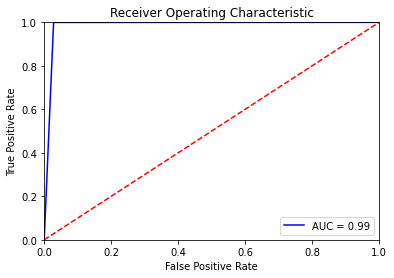

In [333]:
# ROC CURVE FOR THE RF MODEL
probs = rf.predict_proba(newdata)  
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(test_data['is_returned'], new_data_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

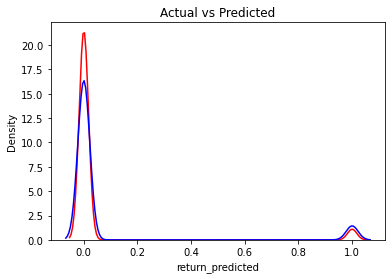

In [277]:
ax = sns.distplot(predictions['return_actual'], hist=False, color="r", label="Actual Value")
sns.distplot(predictions['return_predicted'], hist=False, color="b", label="Fitted Values" , ax=ax)
plt.title('Actual vs Predicted')
plt.show()
plt.close()

In [334]:
train_data['PD'] = rf.predict_proba(train_data[X_train.columns])[:,1]
train_data[['idProduct', 'PD']].tail()

,idProduct,PD
531087,106136759,0.000902
531088,106136874,0.385574
531089,106139088,0.000902
531090,106139135,0.498929
531091,106139209,0.000902


In [335]:
train_data.head()

,idProduct,Product_Age,is_returned,Desc_count,Seller_Age,QTY,PD
0,8,2.0,0,0,0.0,10,0.098648
1,9,2.0,0,0,0.0,5,0.000902
2,14,2.0,0,0,0.0,19,0.130740
3,16,2.0,0,0,0.0,3,0.000902
4,37,2.0,0,0,0.0,3,0.000902


In [336]:
test_data['PD'] = rf.predict_proba(test_data[X_train.columns])[:,1]
test_data[['idProduct', 'PD']].tail()

,idProduct,PD
531086,106136571.0,0.000902
531088,106136874.0,0.385574
531089,106139088.0,0.000902
531090,106139135.0,0.498929
531091,106139209.0,0.000902


In [337]:
test_data.tail()

,idProduct,Product_Age,is_returned,Desc_count,Seller_Age,QTY,PD
531086,106136571.0,2.0,0.0,0.0,0.0,1.0,0.000902
531088,106136874.0,1.0,0.0,179.0,0.0,3.0,0.385574
531089,106139088.0,2.0,0.0,0.0,0.0,1.0,0.000902
531090,106139135.0,2.0,0.0,55.0,1.0,1.0,0.498929
531091,106139209.0,2.0,0.0,0.0,0.0,1.0,0.000902


In [340]:
# new_data - Product_Age, Desc_count, Seller_Age, QTY_sold

pred_test = np.array([0,150,0,2]).reshape(1, -1)
new_pred = rf.predict_proba(pred_test)[:,1][0]
print("\033[1m This product id has a {:.2%}".format(new_pred), "chance of being returned")

 This product id has a 38.39% chance of being returned
